In [13]:
import os
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms
import random

plt.style.use('seaborn')
seed = 3689
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

"""Use turn_off_BN as the handle
   for turning off BN and running the experiments for unnormalized nets"""
turn_off_BN = True
#number of steps to run for
step_limit = 2

cuda:0


In [14]:
#generating training and testing data
d=784
k=10

transform = transforms.Compose(
    [  # transforms.Resize(10),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])

train_length = 10000
batch_size = 64
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
indices = np.random.choice(len(trainset), train_length, replace=False)
trainset_1 = torch.utils.data.Subset(trainset, indices)
trainloader = torch.utils.data.DataLoader(trainset_1, batch_size=batch_size,
                                               shuffle=False, num_workers=0)
#loads the entire train dataset in a single batch, used for creating equivalent BN network
trainloader2 = torch.utils.data.DataLoader(trainset_1, batch_size=len(trainset_1),
                                               shuffle=False, num_workers=4)
test_length = 10000
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
indices = np.random.choice(len(testset), test_length, replace=False)
testset_1 = torch.utils.data.Subset(testset, indices)
testloader = torch.utils.data.DataLoader(testset_1, batch_size=len(testset_1),
                                         shuffle=False, num_workers=0)

"""always keep BN True, as we want to initialize both networks at same point"""
BN_momentum = 0.1
num_layers = 10
neurons = 100
monitor_all = True
is_bias = True
BN=True
gamma_1= True
beta_1 = True
act = 'relu'
lr = 1
tot_epochs = 1

best_val_acc = 0
sgrad_norm_layers = []
sgrad_norm = []
gamma_grad_norm = []
lr_changes_steps = []
lr_changes_epochs = []
if act!='linear':
    fracs = []
cond_numbers = []
max_sv = []
min_sv = []
grad_ratios = []
w_norm_layers = []
pre_acts = []
acts = []
norm_gamma = []
acts_grad = []
pre_acts_grad = []
if BN:
    if gamma_1 and beta_1:
        gammas = []
        abs_gammas = []
        betas = []
        abs_betas = []
        abs_gammas_sigmas = []
    elif gamma_1:
        gammas = []
        abs_gammas = []
        abs_gammas_sigmas = []
    elif beta_1:
        betas = []
        abs_betas = []

for i in range(num_layers):
    cond_numbers.append([])
    w_norm_layers.append([])
    sgrad_norm_layers.append([])
    max_sv.append([])
    min_sv.append([])
    pre_acts.append([])
    pre_acts_grad.append([])
    if i!=num_layers-1:
        acts.append([])
        acts_grad.append([])
    if act!='linear' and i!=num_layers-1:
        fracs.append([])
    if BN and i!=num_layers-1:
        if gamma_1 and beta_1:
            gammas.append([])
            abs_gammas.append([])
            betas.append([])
            abs_betas.append([])
            abs_gammas_sigmas.append([])
            gamma_grad_norm.append([])
            norm_gamma.append([])
        elif gamma_1:
            gammas.append([])
            abs_gammas.append([])
            abs_gammas_sigmas.append([])
            gamma_grad_norm.append([])
            norm_gamma.append([])
        elif beta_1:
            betas.append([])
            abs_betas.append([])

    if i != num_layers-1:
        grad_ratios.append([])

class TestNet(nn.Module):
    def __init__(self, n_layers, d, neurons, k, is_bias, act):
        super(TestNet, self).__init__()
        self.linears = nn.ModuleList()
        self.d = d
        if BN:
            if gamma_1 and beta_1:
                self.gamma = nn.ParameterList()
                self.beta = nn.ParameterList()
            elif gamma_1:
                self.gamma = nn.ParameterList()
            elif beta_1:
                self.beta = nn.ParameterList()
        self.running_mean = []
        self.running_var = []
        for i in range(n_layers):
            if i==0:
                if n_layers==1:
                    self.linears.append(nn.Linear(d, k, bias=is_bias))
                else:
                    self.linears.append(nn.Linear(d, neurons, bias=is_bias))
                    self.running_mean.append(torch.zeros(1,neurons).to(device))
                    self.running_var.append(torch.zeros(1,neurons).to(device))
                    if BN:
                        if gamma_1 and beta_1:
                            self.gamma.append(nn.Parameter(torch.ones(1, neurons).to(device)))
                            self.beta.append(nn.Parameter(torch.zeros(1, neurons).to(device)))
                        elif gamma_1:
                            self.gamma.append(nn.Parameter(torch.ones(1, neurons).to(device)))
                        elif beta_1:
                            self.beta.append(nn.Parameter(torch.zeros(1, neurons).to(device)))
            elif i==n_layers-1:
                self.linears.append(nn.Linear(neurons, k, bias=is_bias))
            else:
                self.linears.append(nn.Linear(neurons, neurons, bias=is_bias))
                self.running_mean.append(torch.zeros(1, neurons).to(device))
                self.running_var.append(torch.zeros(1, neurons).to(device))
                if BN:
                    if gamma_1 and beta_1:
                        self.gamma.append(nn.Parameter(torch.ones(1, neurons).to(device)))
                        self.beta.append(nn.Parameter(torch.zeros(1, neurons).to(device)))
                    elif gamma_1:
                        self.gamma.append(nn.Parameter(torch.ones(1, neurons).to(device)))
                    elif beta_1:
                        self.beta.append(nn.Parameter(torch.zeros(1, neurons).to(device)))

        self.layers = n_layers
        self.act = act
        self.linears.apply(self.w_init)

    def save_pre_acts_grad(self, i):
        def hook(grad):
            pre_acts_grad[i].append(torch.norm(grad))

        return hook

    def save_acts_grad(self, i):
        def hook(grad):
            acts_grad[i].append(torch.norm(grad))

        return hook

    def forward(self, x, step = 1, record = 0, update_mean_var = 0, update_turn_off_BN = 0):
        global BN
        x = x.view(-1,self.d)
        for i, l in enumerate(self.linears):
            x = l(x)
            mean = torch.mean(x, dim=0, keepdim=True)
            var = torch.var(x, dim=0, keepdim=True)
            if BN:
                if i!=self.layers-1:
                    if self.training:
                        x = (x-mean)/(torch.sqrt(var + 1e-5))
                        if update_mean_var:
                            self.running_mean[i] = BN_momentum*mean.detach() + (1-BN_momentum)*self.running_mean[i]
                            self.running_var[i] = BN_momentum*var.detach() + (1-BN_momentum)*self.running_var[i]
                    else:
                        x = (x-self.running_mean[i])/(torch.sqrt(self.running_var[i] + 1e-5))
                    if gamma_1 and beta_1:
                        x = self.gamma[i]*x + self.beta[i]
                        if update_turn_off_BN:
                            self.linears[i].weight.data = torch.transpose((self.gamma[i]*torch.transpose(self.linears[i].weight,0,1))/(torch.sqrt(var + 1e-5)),0,1)
                            self.linears[i].bias.data = torch.squeeze(((self.gamma[i]*(self.linears[i].bias - mean)/(torch.sqrt(var + 1e-5))) + self.beta[i]), 0)
                    elif gamma_1:
                        x = self.gamma[i] * x
                        if update_turn_off_BN:
                            self.linears[i].weight.data = torch.transpose(((self.gamma[i]*torch.transpose(self.linears[i].weight,0,1))/(torch.sqrt(var + 1e-5))),0,1)
                            self.linears[i].bias.data = torch.squeeze((self.gamma[i]*(self.linears[i].bias - mean)/(torch.sqrt(var + 1e-5))),0)
                    elif beta_1:
                        x = x + self.beta[i]
                        if update_turn_off_BN:
                            self.linears[i].weight.data = torch.transpose(((torch.transpose(self.linears[i].weight,0,1))/(torch.sqrt(var + 1e-5))),0,1)
                            self.linears[i].bias.data = torch.squeeze((((self.linears[i].bias - mean) / (torch.sqrt(var + 1e-5))) + self.beta[i]),0)

            if record:
                if i!=self.layers-1:
                    if act=='relu':
                        t = x > 0
                        fracs[i].append((torch.sum(t).detach() + 0.)/(x.shape[0]*x.shape[1]))
                    elif act == 'hardtanh':
                        t = x < 1
                        t1 = x > -1
                        t2 = t*t1
                        fracs[i].append((torch.sum(t2).detach() + 0.) / (x.shape[0] * x.shape[1]))

                    if BN:
                        if gamma_1 and beta_1:
                            betas[i].append(torch.sum(self.beta[i]).detach()/(self.beta[i].shape[1]))
                            abs_betas[i].append(
                                torch.sum(torch.abs(self.beta[i]) / self.beta[i].shape[1]).detach())
                            gammas[i].append(torch.sum(self.gamma[i]).detach() / self.gamma[i].shape[1])
                            abs_gammas[i].append(
                                torch.sum(torch.abs(self.gamma[i])).detach() / self.gamma[i].shape[1])
                            norm_gamma[i].append(torch.norm(self.gamma[i]).detach())
                            abs_gammas_sigmas[i].append(
                                torch.sum(torch.abs(self.gamma[i]) / torch.sqrt(var + 1e-5)).detach() /
                                self.gamma[i].shape[1])
                        elif gamma_1:
                            gammas[i].append(torch.sum(self.gamma[i]).detach() / self.gamma[i].shape[1])
                            abs_gammas[i].append(
                                torch.sum(torch.abs(self.gamma[i])).detach() / self.gamma[i].shape[1])
                            abs_gammas_sigmas[i].append(
                                torch.sum(torch.abs(self.gamma[i]) / torch.sqrt(var + 1e-5)).detach() /
                                self.gamma[i].shape[1])
                            norm_gamma[i].append(torch.norm(self.gamma[i]).detach())
                        elif beta_1:
                            betas[i].append(torch.sum(self.beta[i]).detach() / (self.beta[i].shape[1]))
                            abs_betas[i].append(
                                torch.sum(torch.abs(self.beta[i]) / self.beta[i].shape[1]).detach())

                pre_acts[i].append(torch.norm(x))
                x.register_hook(self.save_pre_acts_grad(i))

                if monitor_all:
                    matrix = np.array(self.linears[i].weight.cpu().data)
                    u = np.linalg.svd(matrix, compute_uv=False)
                    cond_numbers[i].append(np.max(u) / np.min(u))
                    max_sv[i].append(np.max(u))
                    min_sv[i].append(np.min(u))

            if i!=self.layers-1 and self.act!='linear':
                if self.act=='relu':
                    x = F.relu(x)
                elif self.act=='hardtanh':
                    x = F.hardtanh(x)

            if self.act!='linear' and i!=self.layers-1 and record:
                acts[i].append(torch.norm(x))
                x.register_hook(self.save_acts_grad(i))

        if update_turn_off_BN:
            BN = False
        return x

    def w_init(self, m):
        if type(m) == nn.Linear:
            if is_bias:
                m.bias.data.fill_(0.0)
            nn.init.kaiming_normal_(m.weight)

In [15]:
if __name__ == '__main__':
    np.set_printoptions(suppress=True)
    if train_length%batch_size==0:
        train_steps = int(train_length/batch_size)
    else:
        train_steps = int(train_length/batch_size) + 1
    net = TestNet(num_layers, d, neurons, k, is_bias, act)
    net.to(device)
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    old_sgrad = None
    old_grad = None
    criterion = torch.nn.functional.cross_entropy
    curr_index = 0
    optimizer = optim.SGD(net.parameters(), lr)
    check = False
    best_epoch_past = 0
    for epoch in range(tot_epochs):  # loop over the dataset multiple times
        net = net.train()
        running_loss = 0.0
        acc = 0.0
        for i, data in enumerate(trainloader, 0):
            step = epoch * train_steps + i
            if step==step_limit:
                break
            if i==0:
                for name, param in net.named_parameters():
                    for j in range(num_layers):
                        if name == 'linears.' + str(j) + '.weight':
                            w_norm_layers[j].append(torch.norm(param))

            inputs, labels = data[0].to(device), data[1].to(device)
            if i==0 and epoch==0 and turn_off_BN:
                with torch.no_grad():
                    outputs = net(inputs, 1, 0, 0, 1)
                    print(BN)
                    outputs2 = net(inputs, 1, 0, 0)
                    print(torch.max(torch.abs(outputs-outputs2)))
            optimizer.zero_grad()
            outputs = net(inputs, step, 1, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            indices = torch.argmax(outputs, 1)
            acc = acc + torch.sum(indices == labels)

            # if i % 10 == 0:
            tot_grad = 0
            grads = np.zeros((num_layers))
            for name, param in net.named_parameters():
                if param.grad is not None:
                    tot_grad += torch.norm(param.grad)**2
                for j in range(num_layers):
                    if name == 'linears.' + str(j) + '.weight':
                        grads[j] = torch.norm(param.grad)
                        sgrad_norm_layers[j].append(torch.norm(param.grad))
                        w_norm_layers[j].append(torch.norm(param))
                    if name == 'gamma.' + str(j) and param.grad is not None:
                        gamma_grad_norm[j].append(torch.norm(param.grad))
            sgrad_norm.append(torch.sqrt(tot_grad))
            if monitor_all:
                for j in range(num_layers-1):
                    grad_ratios[j].append(grads[num_layers-1] / grads[j])

            running_loss += loss.item()
            if i % 500 == 499:
                t = 1
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / i))

        train_loss.append(running_loss / (i + 1))
        train_acc.append(acc.item() / train_length)
        print('[%d] Train loss: %.3f, Train acc: %.3f' %
              (epoch + 1, running_loss / (i + 1), acc.item() / train_length))
        net = net.eval()
        acc = 0.0
        total_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(testloader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = net(inputs)

                loss = criterion(outputs, labels)
                total_loss += loss.item()
                indices = torch.argmax(outputs, 1)
                acc = acc + torch.sum(indices == labels)

        print('[%d] Validation loss: %.3f, Validation acc: %.3f' %
              (epoch + 1, total_loss / (i + 1), acc.item() / test_length))

        test_loss.append(total_loss / (i + 1))
        test_acc.append(acc.item() / test_length)
        if acc.item() / test_length > best_val_acc:
            best_val_acc = acc.item() / test_length

print('Best_val_acc is ' + str(best_val_acc))

False
tensor(1.4067e-05, device='cuda:0')
[1] Train loss: 524.376, Train acc: 0.001
[1] Validation loss: 2278435326860615758118912.000, Validation acc: 0.103
Best_val_acc is 0.1028


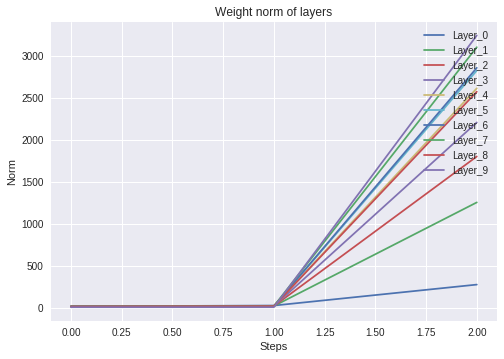

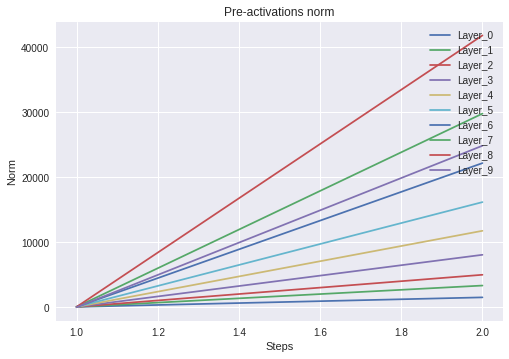

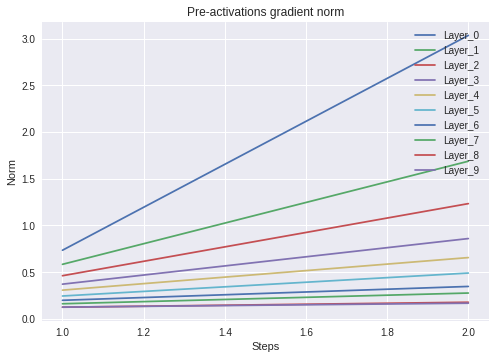

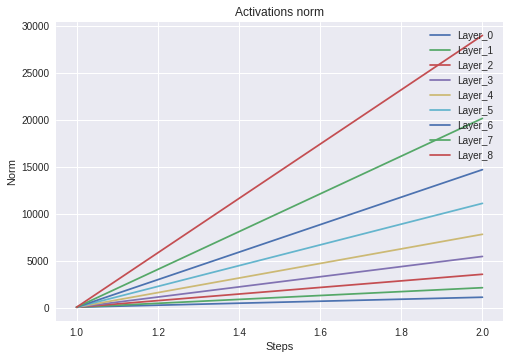

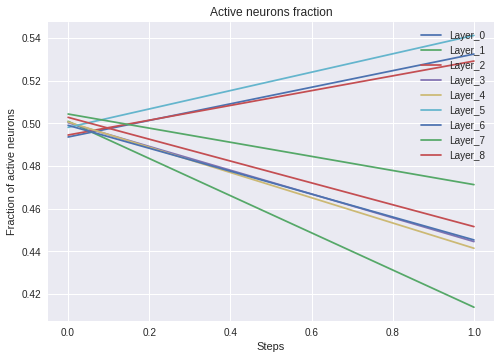

In [16]:
# plt.plot(list(range(len(train_loss))), train_loss, label='train_loss')
# plt.plot(list(range(len(train_loss))), test_loss, label='test_loss')
# plt.legend(loc='upper right')
# plt.xlabel('Steps')
# plt.ylabel('Loss')
# plt.show()
#
# plt.plot(list(range(len(train_loss))), train_acc, label='train_acc')
# plt.plot(list(range(len(train_loss))), test_acc, label='test_acc')
# plt.legend(loc='upper right')
# plt.xlabel('Steps')
# plt.ylabel('Accuracy')
# plt.show()
#
# if monitor_all:
#     a = len(lr_changes_steps)
#     b = np.array(list(range(step + 1)))
#     for j in range(num_layers):
#         temp = np.array(cond_numbers[j])
#         for k in range(len(lr_changes_steps)):
#             if k == 0:
#                 fin = np.ma.masked_where(b > lr_changes_steps[k], temp)
#             else:
#                 fin = np.ma.masked_where((b < lr_changes_steps[k - 1]) | (b > lr_changes_steps[k]), temp)
#             plt.plot(list(range(len(cond_numbers[j]))), fin)
#         if len(lr_changes_steps) == 0:
#             fin = cond_numbers[j]
#         else:
#             fin = np.ma.masked_where(b < lr_changes_steps[k], temp)
#         plt.plot(list(range(len(cond_numbers[j]))), fin)
#         plt.title('cond_number_Weight_' + str(j+1) + '.png')
#         plt.show()
#
#     for j in range(num_layers):
#         temp = np.array(max_sv[j])
#         for k in range(len(lr_changes_steps)):
#             if k == 0:
#                 fin = np.ma.masked_where(b > lr_changes_steps[k], temp)
#             else:
#                 fin = np.ma.masked_where((b < lr_changes_steps[k - 1]) | (b > lr_changes_steps[k]), temp)
#             plt.plot(list(range(len(max_sv[j]))), fin)
#         if len(lr_changes_steps) == 0:
#             fin = max_sv[j]
#         else:
#             fin = np.ma.masked_where(b < lr_changes_steps[k], temp)
#         plt.plot(list(range(len(max_sv[j]))), fin)
#         plt.title('max_sv_Weight_' + str(j + 1) + '.png')
#         plt.show()
#
#     for j in range(num_layers):
#         temp = np.array(min_sv[j])
#         for k in range(len(lr_changes_steps)):
#             if k == 0:
#                 fin = np.ma.masked_where(b > lr_changes_steps[k], temp)
#             else:
#                 fin = np.ma.masked_where((b < lr_changes_steps[k - 1]) | (b > lr_changes_steps[k]), temp)
#             plt.plot(list(range(len(cond_numbers[j]))), fin)
#         if len(lr_changes_steps) == 0:
#             fin = min_sv[j]
#         else:
#             fin = np.ma.masked_where(b < lr_changes_steps[k], temp)
#         plt.plot(list(range(len(min_sv[j]))), fin)
#         plt.title('min_sv_Weight_' + str(j + 1) + '.png')
#         plt.show()

for j in range(num_layers):
    plt.plot(np.arange(len(w_norm_layers[j])), w_norm_layers[j], label='Layer_' + str(j))
plt.legend(loc='upper right')
plt.xlabel('Steps')
plt.ylabel('Norm')
plt.title('Weight norm of layers')
plt.show()

for j in range(num_layers):
    plt.plot(np.arange(len(pre_acts[j])) + 1, pre_acts[j], label='Layer_' + str(j))
plt.legend(loc='upper right')
plt.xlabel('Steps')
plt.ylabel('Norm')
plt.title('Pre-activations norm')
plt.show()

for j in range(num_layers):
    plt.plot(np.arange(len(pre_acts_grad[j])) + 1, pre_acts_grad[j], label='Layer_' + str(j))
plt.legend(loc='upper right')
plt.xlabel('Steps')
plt.ylabel('Norm')
plt.title('Pre-activations gradient norm')
plt.show()

for j in range(num_layers - 1):
    plt.plot(np.arange(len(acts[j])) + 1, acts[j], label='Layer_' + str(j))
plt.legend(loc='upper right')
plt.xlabel('Steps')
plt.ylabel('Norm')
plt.title('Activations norm')
plt.show()

for j in range(num_layers - 1):
    plt.plot(np.arange(len(acts_grad[j])) + 1, acts_grad[j], label='Layer_' + str(j))
plt.legend(loc='upper right')
plt.xlabel('Steps')
plt.ylabel('Norm')
plt.title('Activations gradient norm')
plt.close()

if act != 'linear':
    for j in range(num_layers - 1):
        plt.plot(list(range(len(fracs[j]))), fracs[j], label='Layer_' + str(j))
    plt.legend(loc='upper right')
    plt.xlabel('Steps')
    plt.ylabel('Fraction of active neurons')
    plt.title('Active neurons fraction')
    plt.show()

if BN:
    if gamma_1:
        for j in range(num_layers-1):
            plt.plot(list(range(len(gammas[j]))), gammas[j], label='Layer_' + str(j))
        plt.legend(loc='upper right')
        plt.title('Average gamma value')
        plt.show()

        for j in range(num_layers - 1):
            plt.plot(np.arange(len(norm_gamma[j])), norm_gamma[j], label='Layer_' + str(j))
        plt.legend(loc='upper right')
        plt.title('Gamma norm')
        plt.show()

        for j in range(num_layers - 1):
            plt.plot(np.arange(len(gamma_grad_norm[j])), gamma_grad_norm[j], label='Layer_' + str(j))
        plt.legend(loc='upper right')
        plt.title('Gamma gradient norm')
        plt.show()

        for j in range(num_layers-1):
            plt.plot(list(range(len(abs_gammas[j]))), abs_gammas[j], label='Layer_' + str(j))
        plt.legend(loc='upper right')
        plt.title('Average absolute gamma value')
        plt.show()
    if beta_1:
        for j in range(num_layers-1):
            plt.plot(list(range(len(betas[j]))), betas[j], label='Layer_' + str(j))
        plt.legend(loc='upper right')
        plt.title('Average beta value')
        plt.show()

        for j in range(num_layers-1):
            plt.plot(list(range(len(abs_betas[j]))), abs_betas[j], label='Layer_' + str(j))
        plt.legend(loc='upper right')
        plt.title('Average absolute beta value')
        plt.show()